# Classifying six-figures in malpractice payments

## Imports and taking peek at the data

In [1]:
import itertools
import numpy as np
import pandas as pd 
from scipy import stats
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib as mpl
warnings.filterwarnings('ignore')
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, cross_validate, ShuffleSplit, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('NPDB2401_Modern_Malpractice_Clean.csv')
df

,ISINSURE,WORKSTAT,LICNSTAT,WKNLICEQ,LICNFELD,PRACTAGE,GRAD,ALGNNATR,ALEGATN1,OUTCOME,...,NPMALRPT,NPLICRPT,NPCLPRPT,NPPSMRPT,NPDEARPT,NPEXCRPT,NPGARPT,NPCTMRPT,STATEFUND,MALTIME
0,1,AZ,AZ,1,10,30.0,1990.0,20.0,306.0,9.0,...,2,2,0,0,0,0,0,0,0.0,0
1,1,PA,PA,1,10,50.0,1980.0,1.0,200.0,9.0,...,6,0,0,0,0,0,0,0,0.0,0
2,1,SD,SD,1,651,50.0,1970.0,100.0,316.0,9.0,...,1,0,0,0,0,0,0,0,0.0,0
3,1,NJ,NJ,1,430,20.0,1990.0,60.0,334.0,3.0,...,1,0,0,0,0,0,0,0,0.0,0
4,1,TX,TX,1,10,60.0,1960.0,60.0,108.0,5.0,...,1,0,0,0,0,0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192093,0,CA,CA,1,642,50.0,2000.0,70.0,500.0,3.0,...,1,0,0,0,0,0,0,0,0.0,0
192094,0,NJ,NJ,1,110,50.0,1990.0,10.0,110.0,7.0,...,1,0,0,0,0,0,0,0,0.0,0
192095,0,CT,NJ,0,10,30.0,2010.0,70.0,106.0,6.0,...,1,0,0,0,0,0,0,0,0.0,0
192096,0,MD,NJ,0,10,20.0,2010.0,70.0,106.0,6.0,...,1,0,0,0,0,0,0,0,0.0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192098 entries, 0 to 192097
Data columns (total 29 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ISINSURE   192098 non-null  int64  
 1   WORKSTAT   192098 non-null  object 
 2   LICNSTAT   192098 non-null  object 
 3   WKNLICEQ   192098 non-null  int64  
 4   LICNFELD   192098 non-null  int64  
 5   PRACTAGE   192098 non-null  float64
 6   GRAD       192098 non-null  float64
 7   ALGNNATR   192098 non-null  float64
 8   ALEGATN1   192098 non-null  float64
 9   OUTCOME    192098 non-null  float64
 10  PAYMENT    192098 non-null  float64
 11  PAYNUMBR   192098 non-null  object 
 12  NUMBPRSN   192098 non-null  float64
 13  PAYTYPE    192098 non-null  object 
 14  PYRRLTNS   192098 non-null  object 
 15  PTAGE      192098 non-null  float64
 16  PTGENDER   192098 non-null  object 
 17  PTTYPE     192098 non-null  object 
 18  TYPE       192098 non-null  int64  
 19  NPMALRPT   192098 non-n

### Let's see the distrubtion of the payment column 

<Axes: xlabel='PAYMENT', ylabel='Count'>

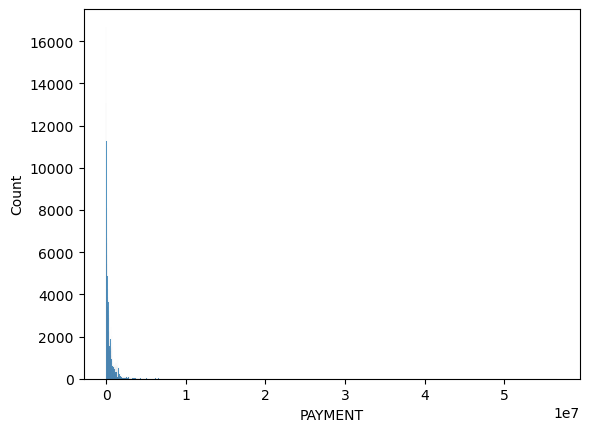

In [4]:
sns.histplot(data=df, x='PAYMENT')

### Let's scale that distrubtion

<Axes: xlabel='PAYMENT', ylabel='Count'>

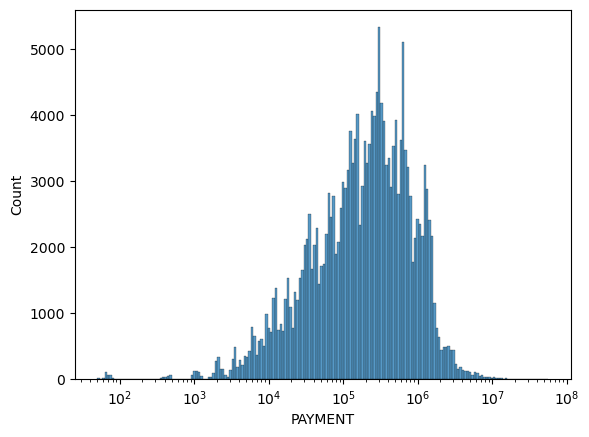

In [5]:
sns.histplot(data=df, x='PAYMENT', log_scale=True)

### Should we classify by the digits of the payment?

In [6]:
log_ref = {}
for i in range(2,9):
    log_ref[i] = len(df[(df['PAYMENT'] > 10**(i-1)) & (df['PAYMENT'] <= 10**(i))])
log_ref 

{2: 291, 3: 363, 4: 8896, 5: 52632, 6: 106392, 7: 23377, 8: 147}

### We should not:
   - Massive class imbalace, most payment are 6 figures 
   - The smaller figuares will be problematic noise
### What will do instead:
   - Classify payments as under, over, or extacly 6 figures using orinal encoding and model for that

In [7]:
df['PAYMENT'] = df['PAYMENT'].map(lambda x: math.ceil(math.log(x, 10)) ).astype(int)
df['PAYMENT'] = df['PAYMENT'].map(lambda x: 2 if x > 6 else (0 if x < 6 else 1))

In [8]:
log_ref = {}
for i in range(df['PAYMENT'].min(),df['PAYMENT'].max()+1):
    log_ref[i] = len(df[df['PAYMENT'] == i])
log_ref 

{0: 62182, 1: 106392, 2: 23524}

### Better, Next Let's look at some numerical correlations to see how each column could affect our models

In [9]:
num_col = ['PAYMENT','GRAD','PRACTAGE', 'NPMALRPT', 'NPLICRPT', 'NPCLPRPT' , 'NPPSMRPT' , 'NPDEARPT', 'NPEXCRPT', 'NPGARPT' ,'NPCTMRPT', 'MALTIME', 'NUMBPRSN', 'PTAGE']
num_df = df[num_col]

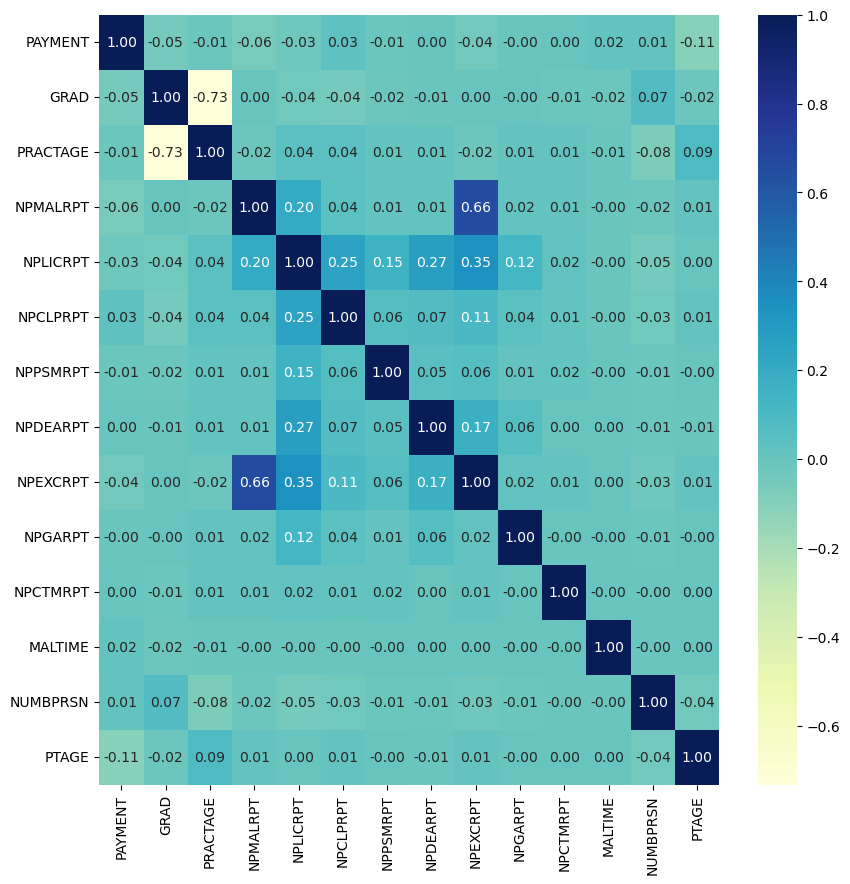

In [10]:
plt.figure(figsize=(10, 10))
sns.heatmap(num_df.corr(), cmap="YlGnBu", annot=True, fmt=".2f")
plt.show()

### The strongest correlations by magnitudes are:
   - Grad and Practage
   - NPExcrpt and NPMalrpt
### Because of that we will remove:
   - Practage and NPExcrpt since Grad and NPMalrpt are more correlated to payments
   - because of the high correlation Practage and NPExcrpt are redundant 

In [11]:
df.drop(df[['PRACTAGE', 'NPEXCRPT']], axis=1, inplace=True)
num_col = list(set(num_df.columns) - set(['PRACTAGE', 'NPEXCRPT','PAYMENT']))
num_df = df[num_col]

### What about the categorical correlations?

### Before that we have clean out the irregular categories from our categorical columns with a lot of categories

In [12]:
cat_cols = list(set(df.columns) - set(num_df.columns))

In [13]:
col_ref = {}
for col in cat_cols:
    col_ref[col]  = len(df[col].unique())
    df[col] = df[col].astype(str)
col_ref

{'PTTYPE': 4,
 'PYRRLTNS': 8,
 'ALGNNATR': 11,
 'PAYNUMBR': 2,
 'ISINSURE': 2,
 'TYPE': 37,
 'PTGENDER': 3,
 'LICNSTAT': 57,
 'LICNFELD': 94,
 'WKNLICEQ': 2,
 'PAYMENT': 3,
 'STATEFUND': 2,
 'OUTCOME': 10,
 'ALEGATN1': 91,
 'WORKSTAT': 59,
 'PAYTYPE': 5}

### 15 or more catagories counts as categorical column with a lot of categories

In [14]:
big_cols = [col for col in col_ref.keys() if col_ref[col] > 15]
big_cols

['TYPE', 'LICNSTAT', 'LICNFELD', 'ALEGATN1', 'WORKSTAT']

### If the catagory appears in less than 1% of the data it will be replaced by a V for Various 

In [15]:
for col in big_cols:
    ref = dict(df[col].value_counts())
    df[col] = df[col].map(lambda x: 'V' if ref[x] < 10**-2*len(df) else x)

In [16]:
col_ref = {}
for col in cat_cols:
    col_ref[col]  = len(df[col].unique())
col_ref

{'PTTYPE': 4,
 'PYRRLTNS': 8,
 'ALGNNATR': 11,
 'PAYNUMBR': 2,
 'ISINSURE': 2,
 'TYPE': 7,
 'PTGENDER': 3,
 'LICNSTAT': 29,
 'LICNFELD': 9,
 'WKNLICEQ': 2,
 'PAYMENT': 3,
 'STATEFUND': 2,
 'OUTCOME': 10,
 'ALEGATN1': 17,
 'WORKSTAT': 27,
 'PAYTYPE': 5}

### Better, now for some more quick cleaning

In [17]:
for col in cat_cols:
    if len(df[col].unique()) == 2: 
        print(f'{col} : {df[col].unique()}')

PAYNUMBR : ['S' 'M']
ISINSURE : ['1' '0']
WKNLICEQ : ['1' '0']
STATEFUND : ['0.0' '1.0']


In [18]:
df['PAYNUMBR'] = df['PAYNUMBR'].map(lambda x: '0' if x == 'S' or x == '0' else '1')
for col in cat_cols:
    if len(df[col].unique()) == 2: 
        print(f'{col} : {df[col].unique()}')

PAYNUMBR : ['0' '1']
ISINSURE : ['1' '0']
WKNLICEQ : ['1' '0']
STATEFUND : ['0.0' '1.0']


### For categorical correlations we have to use cramers_v,  an effect size measurement for the chi-square test of independence,  as our metric

In [19]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))


### Let's get those correlations in a heatmap

In [20]:
cat_cor_cols = cat_cols
corr_matrix = pd.DataFrame(index=cat_cor_cols, columns=cat_cor_cols)
for col1 in cat_cor_cols:
    for col2 in cat_cor_cols:
        if col1 == col2:
            corr_matrix.loc[col1, col2] = 1.0
        else:
            corr_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])
    

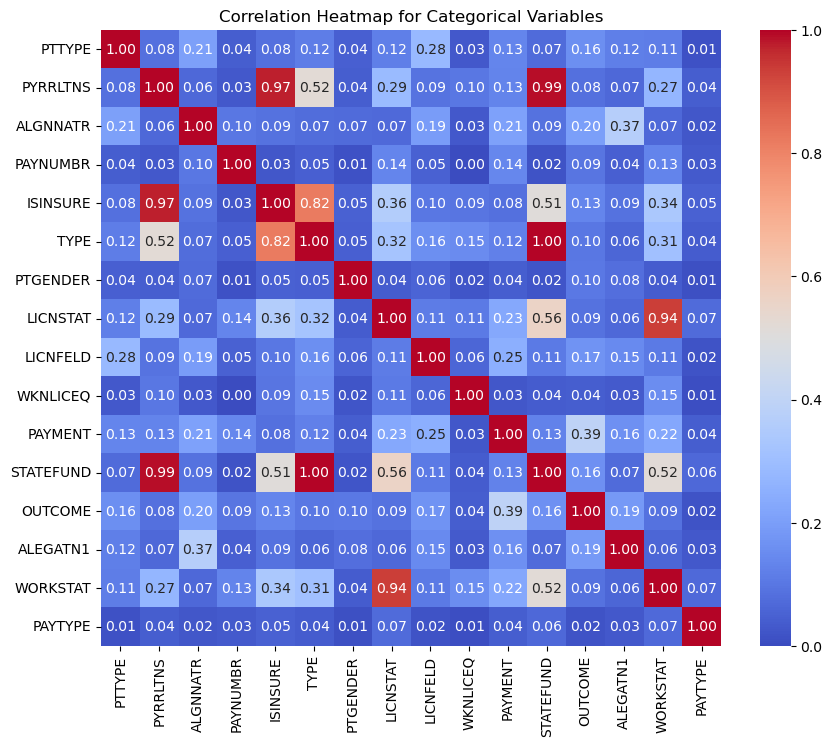

In [21]:
corr_matrix = corr_matrix.astype(float)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1, fmt='.2f')
plt.title('Correlation Heatmap for Categorical Variables')
plt.show()

### We can see:
   - STATEFUND strongly correlates with a handful of the cataories and should be droped
   - ISINSURE strongly correlates with a couple of the cataories and should be droped
   - LICNSTAT correlates well with WORKSTATE and we have stat if both match, and suits are most likly filed in the same state WORKSTATE, LICNSTAT should be droped

In [22]:
df.drop(df[['STATEFUND', 'LICNSTAT', 'ISINSURE']], axis=1, inplace=True)
cat_cols = list(set(cat_cols) - set(['STATEFUND', 'LICNSTAT', 'ISINSURE', 'PAYMENT']))

## Modeling Time

### First training and test split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['PAYMENT'], axis=1) , df['PAYMENT'], test_size=.3, random_state = 31)

### Here an example of how the cataorical columns are encoded, and the columns for both train and test

In [24]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
dummies = ohe.fit_transform(X_train[cat_cols])
X_train_onehot = pd.DataFrame(dummies, columns=ohe.get_feature_names_out(), index=X_train.index)
X_train_Enc = pd.concat([X_train[num_col], X_train_onehot], axis=1)
scaler = StandardScaler()
X_train_Enc_ss = scaler.fit_transform(X_train_Enc)
len(X_train) == len(X_train_Enc_ss)

True

In [25]:
dummies = ohe.transform(X_test[cat_cols])
X_test_onehot = pd.DataFrame(dummies, columns=ohe.get_feature_names_out(), index=X_test.index)
X_test_Enc = pd.concat([X_test[num_col], X_test_onehot], axis=1)
X_test_Enc_ss = scaler.transform(X_test_Enc)
len(X_test) == len(X_test_Enc_ss)

True

### Let's try a simple Decision Tree Classifier

In [26]:
model = DecisionTreeClassifier(criterion = 'gini',  max_depth = 4, random_state=42)
model.fit(X_train_Enc_ss, y_train)
accuracy_train = model.score(X_train_Enc_ss, y_train)
accuracy_train

0.654728262486242

### What were the important features, and how important are they

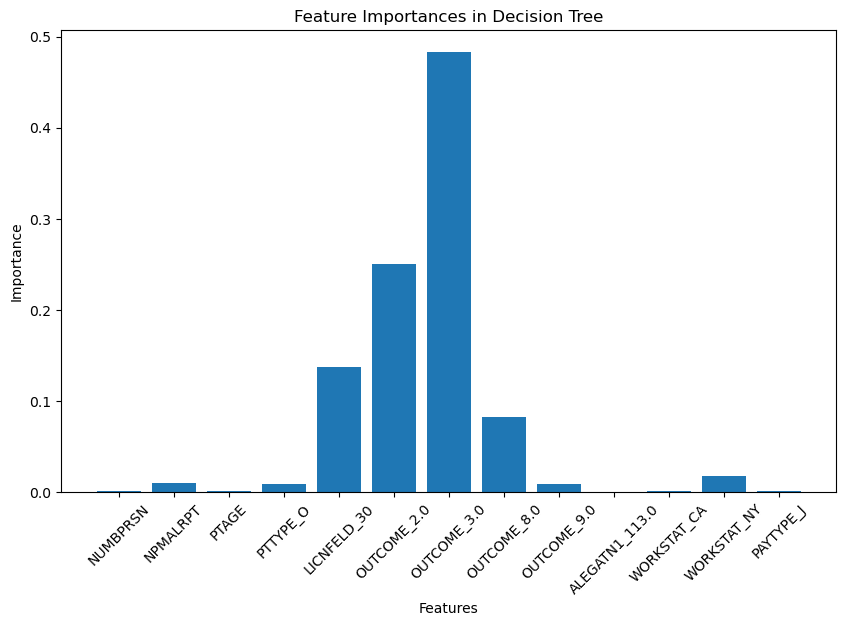

In [27]:
imp_ref = {X_train_Enc.columns[i]: model.feature_importances_[i] for i in range(len(X_train_Enc.columns)) if model.feature_importances_[i] != 0}
plt.figure(figsize=(10, 6))
plt.bar(imp_ref.keys(), imp_ref.values())
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances in Decision Tree')
plt.xticks(rotation=45)
plt.show()

### Let's take a peek into the tree

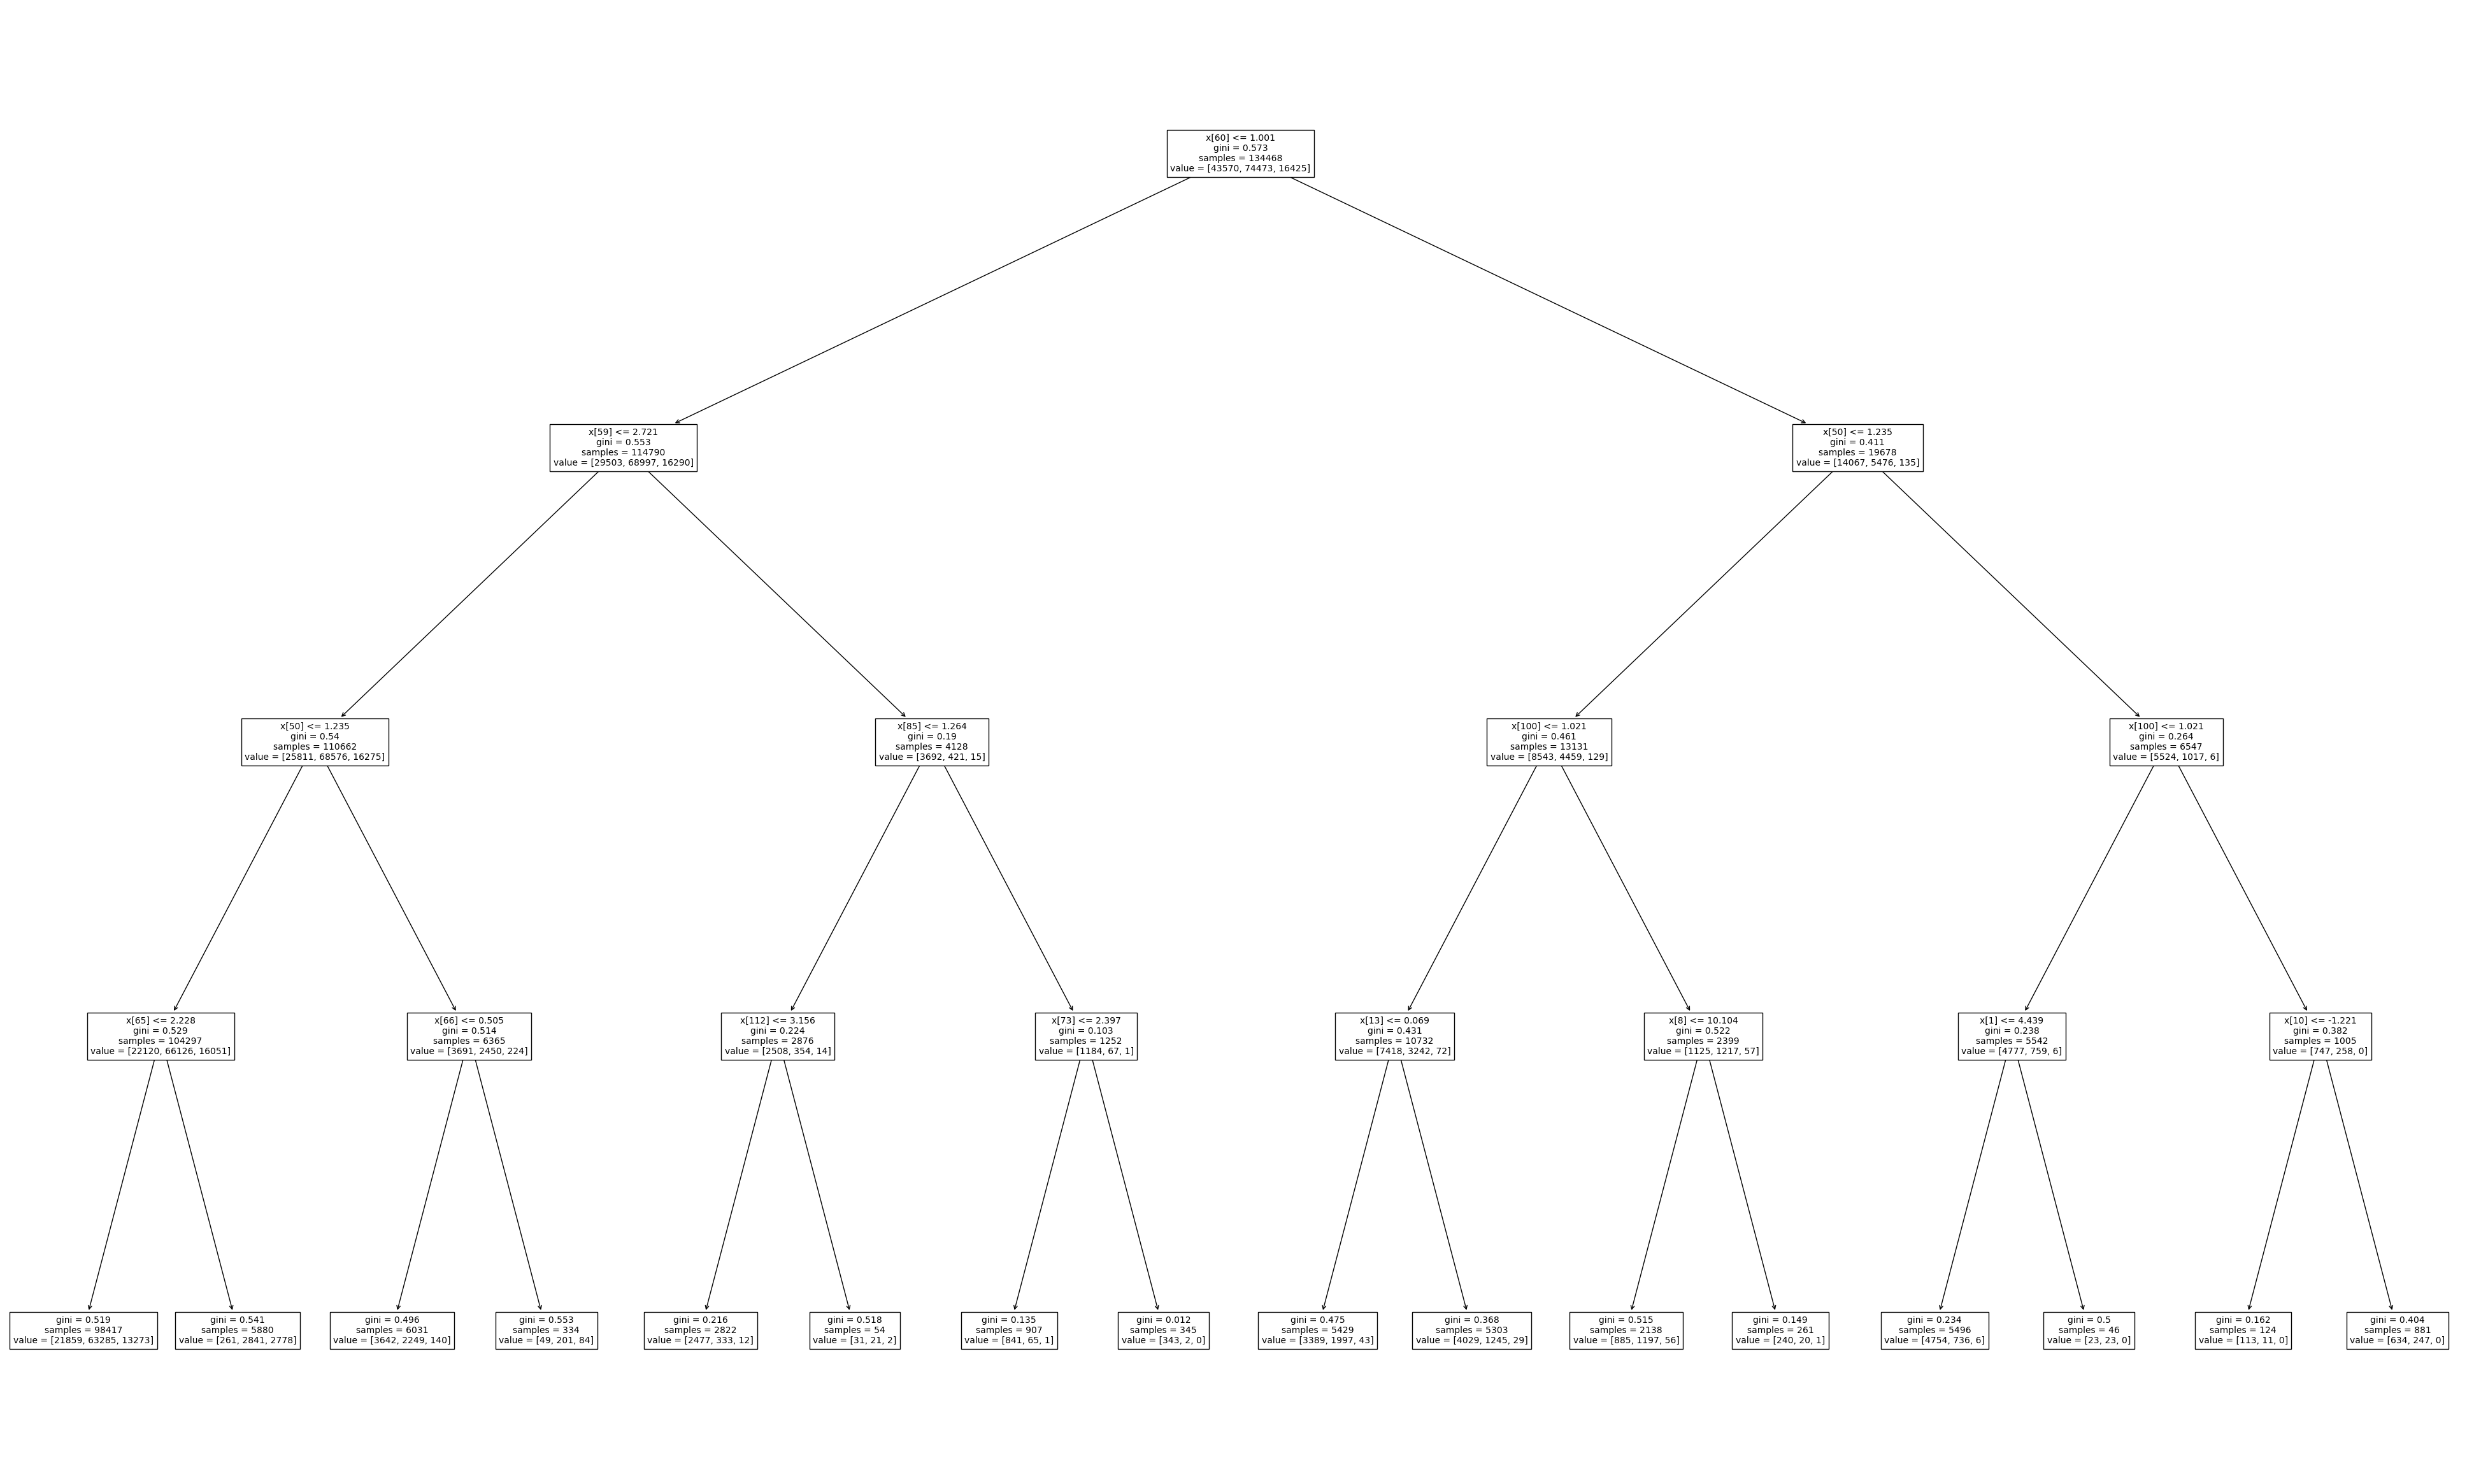

In [28]:
f, ax = plt.subplots(figsize=(50,30))
plot_tree(model, ax=ax, fontsize=10);

### Is there a risk for variance?

### Let's make our own cross_validation method to pervent data leakage and keep our encoding and scaling

In [29]:
def cross_validation(X_train, y_train, model, num_split = 10):
        
    score_train_list = []
    score_val_list = []
    
    for train_index, valid_index in KFold(n_splits = num_split).split(X_train):
        
        # train and validation splitting 
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[valid_index]
        
        ohe = OneHotEncoder(sparse_output=False)
        dummies = ohe.fit_transform(X_train_fold[cat_cols])
        X_train_onehot = pd.DataFrame(dummies, columns=ohe.get_feature_names_out(), index=X_train_fold.index)
        X_train_Enc = pd.concat([X_train_fold[num_col], X_train_onehot], axis=1)
        
        dummies = ohe.transform(X_val_fold[cat_cols])
        X_val_onehot = pd.DataFrame(dummies, columns=ohe.get_feature_names_out(), index=X_val_fold.index)
        X_val_Enc = pd.concat([X_val_fold[num_col], X_val_onehot], axis=1)

        #create/fit the Standard scaler on the train fold
        scaler = StandardScaler()
        X_tf_sc = scaler.fit_transform(X_train_Enc)
        # transform validation fold
        X_vld_sc = scaler.transform(X_val_Enc)

        # Score it
        model.fit(X_tf_sc, y_train_fold)
        
        # now how did we do?
        accuracy_train = model.score(X_tf_sc, y_train_fold)
        accuracy_val = accuracy_score(y_val_fold, model.predict(X_vld_sc))
        score_val_list.append(accuracy_val)
        score_train_list.append(accuracy_train)
    
    return {'train': np.mean(score_train_list), 'validation': np.mean(score_val_list)}

In [30]:
cross_validation(X_train, y_train, model)

{'train': 0.6548265914223718, 'validation': 0.6545050753792018}

### There does not seem to be. 

### Let's try uping the max_depth

In [31]:
g_model = DecisionTreeClassifier(criterion = 'gini',  max_depth = 7, random_state=42)
g_model.fit(X_train_Enc_ss, y_train)
accuracy_train = g_model.score(X_train_Enc_ss, y_train)
accuracy_train

0.6751792247969777

In [32]:
cross_validation(X_train, y_train, g_model)

{'train': 0.6750594100547802, 'validation': 0.6733497486139497}

### A seeming minmal risk of variance
### Important features?

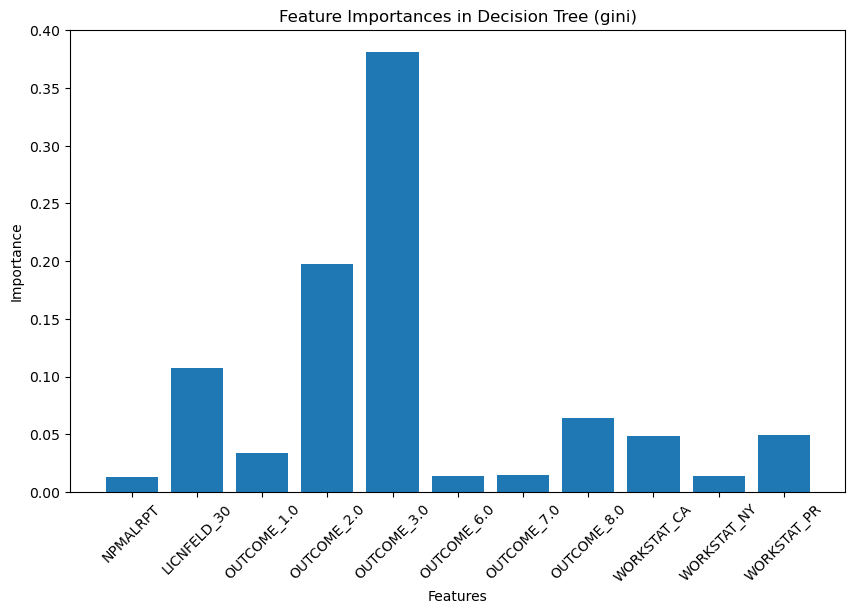

In [33]:
imp_ref = {X_train_Enc.columns[i]: g_model.feature_importances_[i] for i in range(len(X_train_Enc.columns)) if g_model.feature_importances_[i] > .01}
plt.figure(figsize=(10, 6))
plt.bar(imp_ref.keys(), imp_ref.values())
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances in Decision Tree (gini)')
plt.xticks(rotation=45)
plt.show()

### Same model but with a entropy criterion

In [34]:
e_model = DecisionTreeClassifier(criterion = 'entropy',  max_depth = 7, random_state=42)
e_model.fit(X_train_Enc_ss, y_train)
accuracy_train = e_model.score(X_train_Enc_ss, y_train)
accuracy_train

0.6658907695511199

In [35]:
cross_validation(X_train, y_train, e_model, num_split = 10)

{'train': 0.6667104610921867, 'validation': 0.6653106265074179}

### A seeming minmal risk of variance
### Important features?

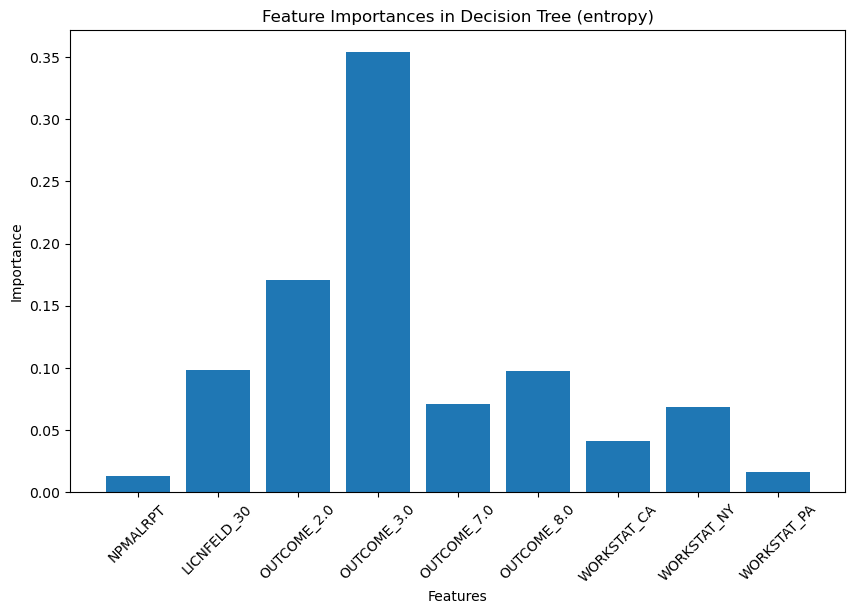

In [36]:
imp_ref = {X_train_Enc.columns[i]: e_model.feature_importances_[i] for i in range(len(X_train_Enc.columns)) if e_model.feature_importances_[i] > .01}
plt.figure(figsize=(10, 6))
plt.bar(imp_ref.keys(), imp_ref.values())
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances in Decision Tree (entropy)')
plt.xticks(rotation=45)
plt.show()

### Let's see the final results for the entropy criterion model

In [37]:
accuracy_score(y_test, e_model.predict(X_test_Enc_ss))

0.664133263925039

### In more detail

In [38]:
print(classification_report(y_test, e_model.predict(X_test_Enc_ss)))

              precision    recall  f1-score   support

           0       0.77      0.45      0.57     18612
           1       0.65      0.89      0.75     31919
           2       0.55      0.23      0.32      7099

    accuracy                           0.66     57630
   macro avg       0.66      0.52      0.55     57630
weighted avg       0.67      0.66      0.64     57630



### In visual detail

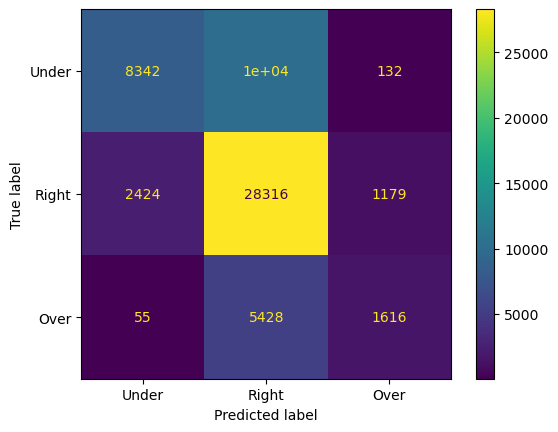

In [39]:
cfmat = confusion_matrix(y_test, e_model.predict(X_test_Enc_ss))

ConfusionMatrixDisplay(cfmat,display_labels=['Under', 'Right', 'Over']).plot()

### Let's see the final results for the gini criterion model with max_depth 7

In [40]:
accuracy_score(y_test, g_model.predict(X_test_Enc_ss))

0.6745271559951415

### In more detail

In [41]:
print(classification_report(y_test, g_model.predict(X_test_Enc_ss)))

              precision    recall  f1-score   support

           0       0.72      0.57      0.64     18612
           1       0.67      0.85      0.75     31919
           2       0.56      0.15      0.24      7099

    accuracy                           0.67     57630
   macro avg       0.65      0.53      0.54     57630
weighted avg       0.67      0.67      0.65     57630



### In visual detail

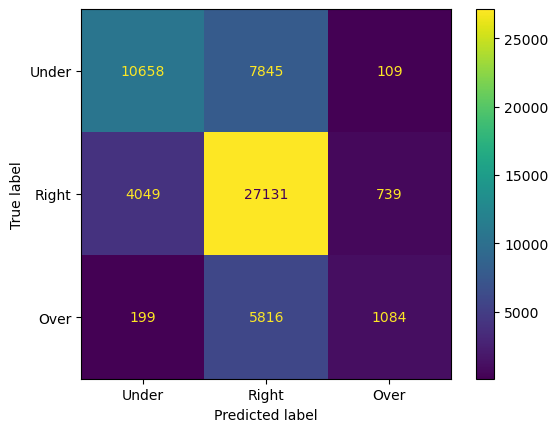

In [42]:
cfmat = confusion_matrix(y_test, g_model.predict(X_test_Enc_ss))

ConfusionMatrixDisplay(cfmat,display_labels=['Under', 'Right', 'Over']).plot()

### Lastly, our oringal base tree model

In [43]:
accuracy_score(y_test, model.predict(X_test_Enc_ss))

0.6537046677077911

### In more detail

In [44]:
print(classification_report(y_test, model.predict(X_test_Enc_ss)))

              precision    recall  f1-score   support

           0       0.74      0.47      0.57     18612
           1       0.63      0.91      0.74     31919
           2       0.00      0.00      0.00      7099

    accuracy                           0.65     57630
   macro avg       0.46      0.46      0.44     57630
weighted avg       0.59      0.65      0.60     57630



### In visual detail

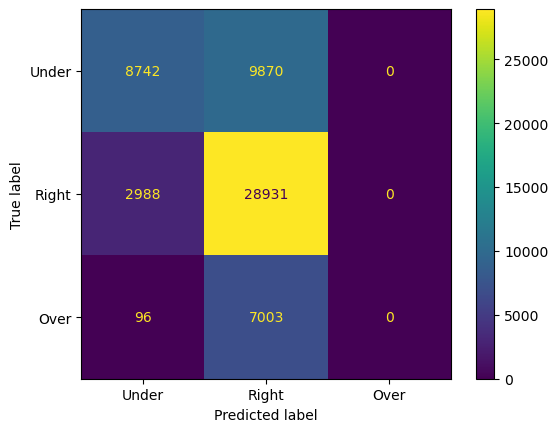

In [45]:
cfmat = confusion_matrix(y_test, model.predict(X_test_Enc_ss))

ConfusionMatrixDisplay(cfmat,display_labels=['Under', 'Right', 'Over']).plot()

## Decision Tree Classifier Summary:

### Best model is gini criterion model with max_depth 7 by accuracy

### We can tell what is important, but not how impactful it for the payment.

## Let's try Logistical Regression
### We can find out only what is important, but how impactful it for the payment.
### Starting with a basic model

In [46]:
model_log_basic = LogisticRegression()
model_log_basic.fit(X_train_Enc_ss, y_train)
model_log_basic.score(X_train_Enc_ss, y_train)

0.688453758515037

In [47]:
cross_validation(X_train, y_train, model_log_basic, num_split = 10)

{'train': 0.6883934376890879, 'validation': 0.6880000527851693}

### A seeming minmal risk of variance
### Important weights?

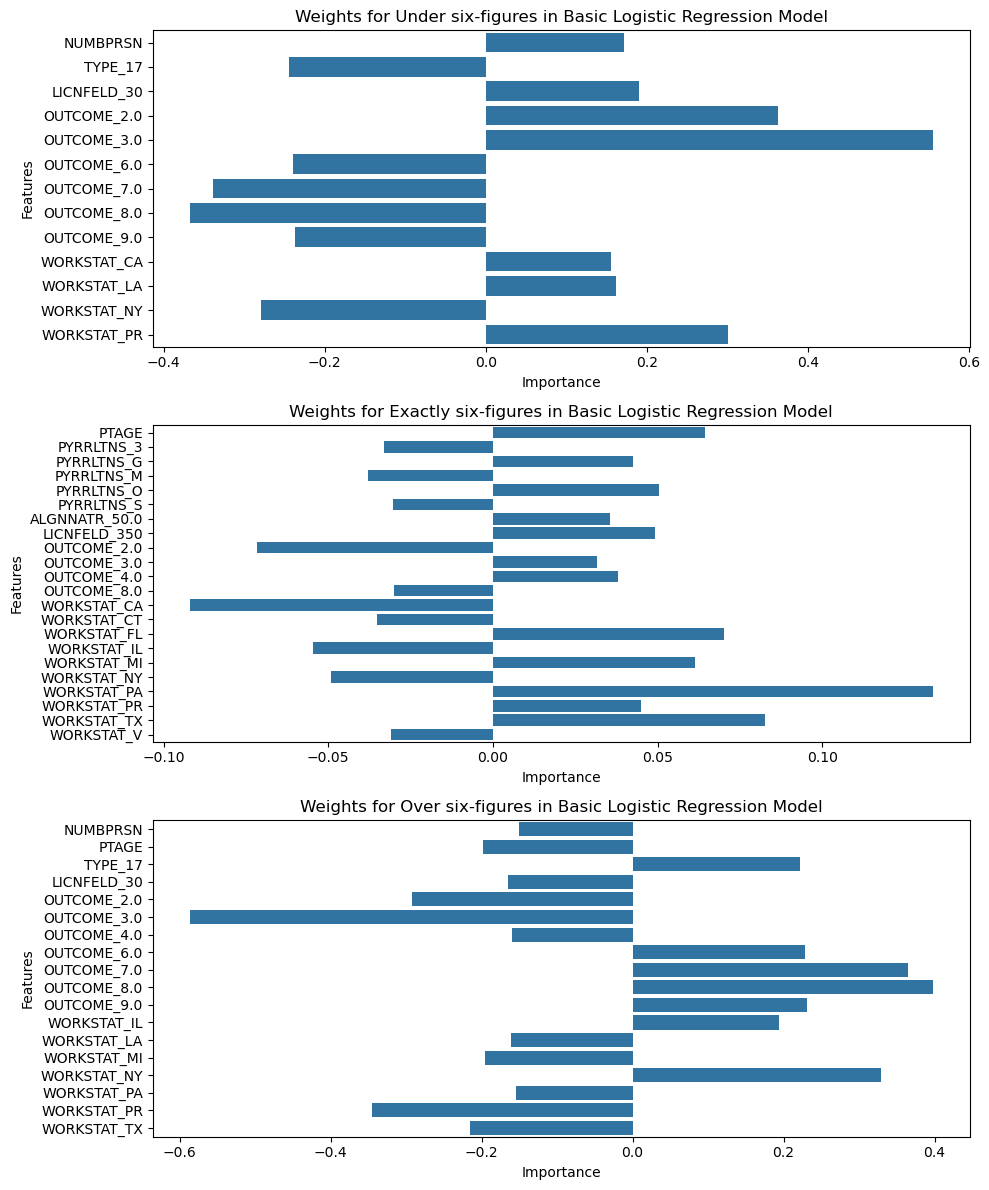

In [48]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))
cat = ['Under', 'Exactly', 'Over']
thersh = [.15, .03, .15]
for i in range(3):
    imp_ref = {X_train_Enc.columns[k]: model_log_basic.coef_[i][k] for k in range(len(X_train_Enc.columns)) if np.abs(model_log_basic.coef_[i][k]) >= thersh[i]}
    sns.barplot(y=imp_ref.keys(), x=imp_ref.values(), orient='h', ax=axes[i])
    axes[i].set_xlabel('Importance')
    axes[i].set_ylabel('Features')
    axes[i].set_title(f'Weights for {cat[i]} six-figures in Basic Logistic Regression Model')
plt.tight_layout()
plt.show()

### Let's try optimizing 
### What is the best C?

In [49]:
def log_hyper_opt(X_train, y_train):
    C_list = [1e-4,1e-3, 1e-2, 1e-1, 1, 10, 100, 1e3]
    cv_scores = {}
    for c in C_list:
        logreg = LogisticRegression(C = c)
        cv_loop_results = cross_validation(X_train, y_train, logreg, num_split = 10)
        cv_scores[c] = cv_loop_results['validation']
    return cv_scores

### WARING this script is UBER SLOW

In [ ]:
log_hyper_opt(X_train, y_train)

### C = 10 is  the best (in case you did not run the above cell)

In [51]:
model_log_c10 = LogisticRegression(C=10)
model_log_c10.fit(X_train_Enc_ss, y_train)
model_log_c10.score(X_train_Enc_ss, y_train)

0.6884686319421721

### A seeming minmal risk of variance
### Important weights?

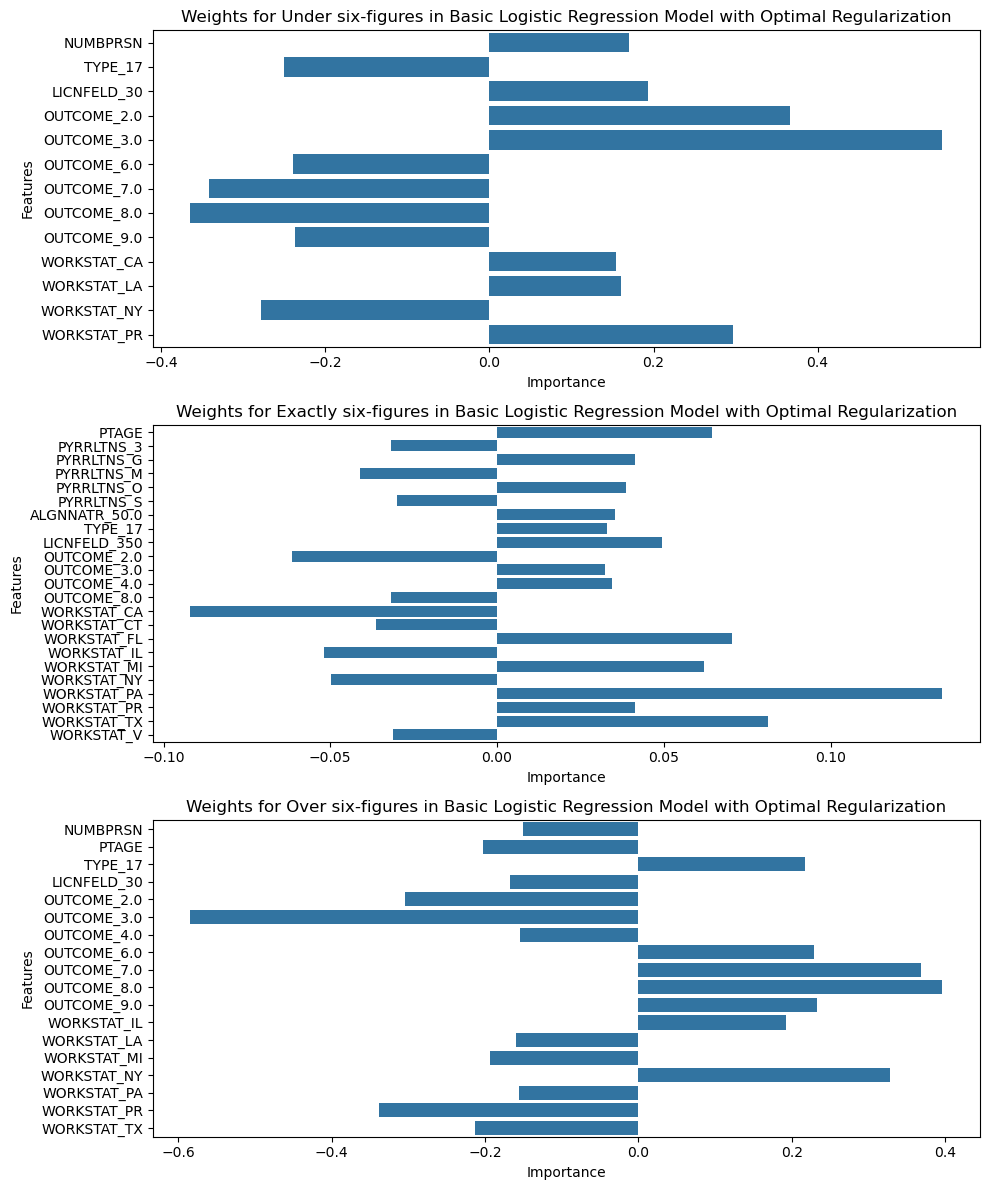

In [52]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))
cat = ['Under', 'Exactly', 'Over']
thersh = [.15, .03, .15]
for i in range(3):
    imp_ref = {X_train_Enc.columns[k]: model_log_c10.coef_[i][k] for k in range(len(X_train_Enc.columns)) if np.abs(model_log_c10.coef_[i][k]) >= thersh[i]}
    sns.barplot(y=imp_ref.keys(), x=imp_ref.values(), orient='h', ax=axes[i])
    axes[i].set_xlabel('Importance')
    axes[i].set_ylabel('Features')
    axes[i].set_title(f'Weights for {cat[i]} six-figures in Basic Logistic Regression Model with Optimal Regularization')
plt.tight_layout()
plt.show()

### Is there a better solver?
### WARING this script is UBER SLOW

In [ ]:
solver_ref = {}.fromkeys(['newton-cg', 'sag', 'saga', 'lbfgs']) 
for s in solver_ref.keys():
    model_log_c10_slove = LogisticRegression(C=10, solver=s)
    model_log_c10_slove.fit(X_train_Enc_ss, y_train)
    solver_ref[s] = model_log_c10_slove.score(X_train_Enc_ss, y_train)
solver_ref

### Newton-cg is the best 

In [ ]:
model_log_c10_newton = LogisticRegression(C=10, solver='newton-cg')
model_log_c10_newton.fit(X_train_Enc_ss, y_train)
cross_validation(X_train, y_train, model_log_c10_newton, num_split = 10)

### A seeming minmal risk of variance
### Important weights?

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))
cat = ['Under', 'Exactly', 'Over']
thersh = [.15, .03, .15]
for i in range(3):
    imp_ref = {X_train_Enc.columns[k]: model_log_c10.coef_[i][k] for k in range(len(X_train_Enc.columns)) if np.abs(model_log_c10.coef_[i][k]) >= thersh[i]}
    sns.barplot(y=imp_ref.keys(), x=imp_ref.values(), orient='h', ax=axes[i])
    axes[i].set_xlabel('Importance')
    axes[i].set_ylabel('Features')
    axes[i].set_title(f'Weights for {cat[i]} six-figures in Basic Logistic Regression Model with Optimal Regularization')
plt.tight_layout()
plt.show()

## Let's see the final results for the Logistical Regression models

### Basic Model

In [ ]:
accuracy_score(y_test, model_log_basic.predict(X_test_Enc_ss))

### In more detail

In [ ]:
print(classification_report(y_test, model_log_basic.predict(X_test_Enc_ss)))

### In visual detail

In [ ]:
cfmat = confusion_matrix(y_test, model_log_basic.predict(X_test_Enc_ss))

ConfusionMatrixDisplay(cfmat,display_labels=['Under', 'Right', 'Over']).plot()

### Default Solver with C=10

In [ ]:
accuracy_score(y_test, model_log_c10.predict(X_test_Enc_ss))

### In more detail

In [ ]:
print(classification_report(y_test, model_log_c10.predict(X_test_Enc_ss)))

### In visual detail

In [ ]:
cfmat = confusion_matrix(y_test, model_log_c10.predict(X_test_Enc_ss))

ConfusionMatrixDisplay(cfmat,display_labels=['Under', 'Right', 'Over']).plot()

### Solver with newton-cg with C=10

In [ ]:
accuracy_score(y_test, model_log_c10_newton.predict(X_test_Enc_ss))

### In more detail

In [ ]:
print(classification_report(y_test, model_log_c10_newton.predict(X_test_Enc_ss)))

### In visual detail

In [ ]:
cfmat = confusion_matrix(y_test, model_log_c10.predict(X_test_Enc_ss))

ConfusionMatrixDisplay(cfmat,display_labels=['Under', 'Right', 'Over']).plot()

## Logistic Regression Summary:
   
### They all preforms similarly but C=10 and lbfgs solver preforms the best

### Important notes
   - The higher the outcome, the more severe the injury to the patient (1 to 9 only)
   - Where the practitioner is working matters

# Summary

### Best model is a C=10 and lbfgs solver logistical regression and it call t

## Recomendtions:
   - If you are a malpratice insurce company look into spending more in advertising in New York, and illinois. According to our model thoes states tend to a have higher than a six-figures malpratice settlements. You can pull funding from advertising in Puerto Rico and to advertising to dentist, since those payments tend to be smaller than six-figures according to the model. 

   - As lawyer, as you may expect, outcome is the most important factor it worth focusing on that when coming to a decision of giving a six-figure settlment or something higher or lower than that. The more server the higher the outcome (1-9).
   
## What is next
   - An EDA to fine tune the recomendtions.
   - Maybe try a regression models, but use the classifier methods since the numerical data is encoded,for example PRACTAGE, PTAGE does not give the age of the practitioner or patient respectively rather an age group they belong to. On top of that over half of the data is categorical making hard of tradional regression to work properly.